In [820]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from itertools import product
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [821]:
# Read the training data
df_train = pd.read_csv('./Data/BBC News Train.csv')
# Read the test data
df_test = pd.read_csv('./Data/BBC News Test.csv')



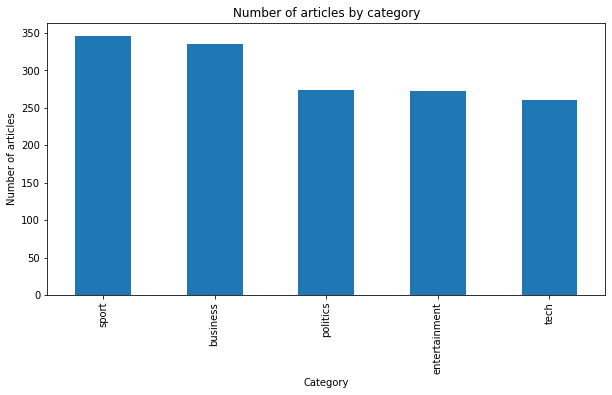

In [822]:
# display by category
df_train['Category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Number of articles by category')
plt.xlabel('Category')
plt.ylabel('Number of articles')
plt.show()


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


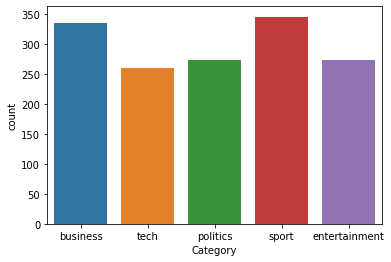

In [823]:
# Plot the distribution of the target variable
sns.countplot(df_train['Category'])
plt.show()


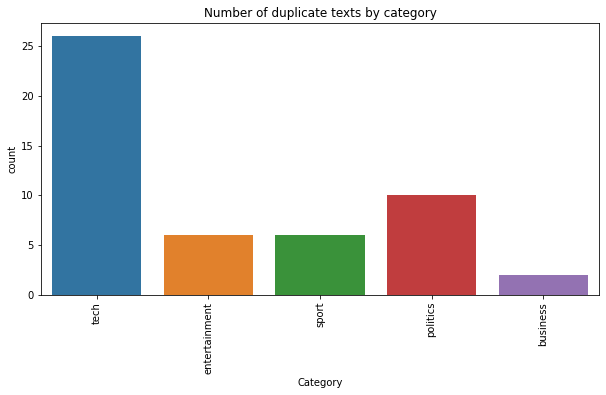

Total number of duplicate texts:  50


In [824]:

# Get the duplicate texts
dup_text = df_train[df_train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text').head(50)
# Plot the number of duplicate text by category
plt.figure(figsize=(10, 5))
# Title of the plot
plt.title('Number of duplicate texts by category')
sns.countplot(x='Category', data=dup_text)
plt.xticks(rotation=90)
plt.show()

# Total number of duplicate texts
print('Total number of duplicate texts: ', len(dup_text))


In [825]:
# Remove the duplicate texts
df_train.drop_duplicates(subset=['Text'], keep='first', inplace=True)
# Reset the index
df_train.reset_index(drop=True, inplace=True)

# Print the shape of the training data
print('Shape of the training data: ', df_train.shape)

Shape of the training data:  (1440, 3)


In [826]:
#Manually encode the target variable
df_train['Category'] = df_train['Category'].map({'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4})
# Print the first 3 rows of the training data
df_train.head(5)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness. cynthia cooper worldcom s ex-head of internal accounting alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy. prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper who now runs her own consulting business told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a green light to the procedures and practices used by worldcom. mr ebber s lawyers have said he was unaware of the fraud arguing that auditors did not alert him to any problems. ms cooper also said that during shareholder meetings mr ebbers often passed over technical questions to the company s finance chief giving only brief answers himself. the prosecution s star witness former worldcom financial chief scott sullivan has said that mr ebbers ordered accounting adjustments at the firm telling him to hit our books . however ms cooper said mr sullivan had not mentioned anything uncomfortable about worldcom s accounting during a 2001 audit committee meeting. mr ebbers could face a jail sentence of 85 years if convicted of all the charges he is facing. worldcom emerged from bankruptcy protection in 2004 and is now known as mci. last week mci agreed to a buyout by verizon communications in a deal valued at $6.75bn.,0
1,154,german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy. munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up. we re surprised that the ifo index has taken such a knock said dz bank economist bernd weidensteiner. the main reason is probably that the domestic economy is still weak particularly in the retail trade. economy and labour minister wolfgang clement called the dip in february s ifo confidence figure a very mild decline . he said that despite the retreat the index remained at a relatively high level and that he expected a modest economic upswing to continue. germany s economy grew 1.6% last year after shrinking in 2003. however the economy contracted by 0.2% during the last three months of 2004 mainly due to the reluctance of consumers to spend. latest indications are that growth is still proving elusive and ifo president hans-werner sinn said any improvement in german domestic demand was sluggish. exports had kept things going during the first half of 2004 but demand for exports was then hit as the value of the euro hit record levels making german products less competitive overseas. on top of that the unemployment rate has been stuck at close to 10% and manufacturing firms including daimlerchrysler siemens and volkswagen have been negotiating with unions over cost cutting measures. analysts said that the ifo figures and germany s continuing problems may delay an interest rate rise by the european central bank. eurozone interest rates are at 2% but comments from senior officials have recently focused on the threat of inflation prompting fears that interest rates may rise.,0
2,1101,bbc poll indicates economic gloom citizens in a majority of nations surveyed in a bbc world service poll believe 

In [827]:
# Write function to clean the text

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert all characters to lowercase
    text = text.lower()
    # Split the text into words
    text = text.split()
    # Remove stopwords
    text = [word for word in text if not word in set(stopwords.words('english'))]
    # Stem the words
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    # Join the words
    text = ' '.join(text)
    return text

# Clean the text
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /Users/kgb-
[nltk_data]     mini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [849]:
df_train

,ArticleId,Text,Category
0,1833,worldcom ex boss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom ex head intern account alert director irregular account practic us telecom giant warn led collaps firm follow discoveri bn bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book howev ms cooper said mr sullivan mention anyth uncomfort worldcom account audit committe meet mr ebber could face jail sentenc year convict charg face worldcom emerg bankruptci protect known mci last week mci agre buyout verizon commun deal valu bn,0
1,154,german busi confid slide german busi confid fell februari knock hope speedi recoveri europ largest economi munich base research institut ifo said confid index fell februari januari first declin three month studi found outlook manufactur retail sector worsen observ hope confid busi sector would signal econom activ pick surpris ifo index taken knock said dz bank economist bernd weidenstein main reason probabl domest economi still weak particularli retail trade economi labour minist wolfgang clement call dip februari ifo confid figur mild declin said despit retreat index remain rel high level expect modest econom upsw continu germani economi grew last year shrink howev economi contract last three month mainli due reluct consum spend latest indic growth still prove elus ifo presid han werner sinn said improv german domest demand sluggish export kept thing go first half demand export hit valu euro hit record level make german product less competit oversea top unemploy rate stuck close manufactur firm includ daimlerchrysl siemen volkswagen negoti union cost cut measur analyst said ifo figur germani continu problem may delay interest rate rise european central bank eurozon interest rate comment senior offici recent focus threat inflat prompt fear interest rate may rise,0
2,1101,bbc poll indic econom gloom citizen major nation survey bbc world servic poll believ world economi worsen respond also said nation economi get wors ask famili financi outlook major countri said posit futur almost peopl countri question poll mostli conduct asian tsunami disast poll found major plural peopl countri believ economi go downhil compar respond nine countri believ improv survey three countri split percentag term averag respond countri said world economi get wors compar said improv similarli pessimist nation economi optimist saw famili econom condit improv said get wors poll peopl conduct intern poll firm globescan togeth program intern polici attitud pipa univers maryland world economi pick difficult time year ago peopl seem fulli absorb develop though person experienc effect said pipa director steven kull peopl around world say ok world may percept war terror religi polit divis make world wors place even though far reflect global econom perform say bbc elizabeth blunt countri peopl optimist world famili two fast grow develop economi china india follow indonesia china seen two decad blister econom growth led wealth creation huge scale say bbc louisa lim beij result also may reflect untrammel confid peopl subject endless govern propaganda countri rosi econom futur correspond say south korea pessimist respond itali mexico also quit gloomi bbc david willey rome say one reason result changeov lira euro wide view biggest reason wage salari worth

In [830]:
X_train = df_train['Text']
y_train = df_train['Category']
X_test = df_test['Text']

In [831]:
print('X_train shape ', X_train.shape)
print('y_train shape ', y_train.shape)
print('X_test shape ', X_test.shape)



X_train shape  (1440,)
y_train shape  (1440,)
X_test shape  (735,)


In [832]:
vectorizer = TfidfVectorizer(encoding = 'utf-8', ngram_range = (1,2),stop_words= None,lowercase = False, max_df = 0.95, min_df = 10,norm = 'l2',sublinear_tf = True)
X = vectorizer.fit_transform(X_train).toarray()
tokens = vectorizer.get_feature_names_out()
print('Number of tokens: ', len(tokens))
print('Number of documents: ', len(X_train))
print('Number of features: ', len(X[0]))




Number of tokens:  4046
Number of documents:  1440
Number of features:  4046


In [872]:
X_df = pd.DataFrame(X, columns=tokens)
print(X_df.sum().sort_values().tail(10))


peopl    26.484767
time     26.655005
one      28.295769
new      29.319374
us       29.593896
also     30.280725
would    32.232761
mr       33.613893
year     38.662227
said     52.770631
dtype: float64


In [861]:
print("Weights given to words by idf:")
pd.DataFrame(vectorizer.idf_, vectorizer.get_feature_names_out(), columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
said,1.165080
year,1.437915
also,1.514455
would,1.655810
one,1.690433
...,...
hop,5.203335
uniqu,5.203335
shoot,5.203335
guard,5.203335


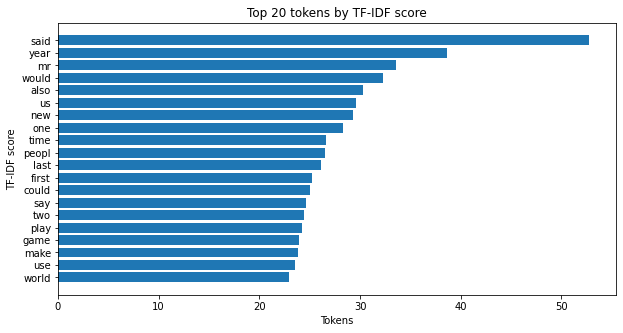

In [833]:
# Plot top 20 tokens by TF-IDF score in descending order with tokens on the x-axis and TF-IDF score on the y-axis
plt.figure(figsize=(10, 5))
plt.title('Top 20 tokens by TF-IDF score')
plt.xlabel('Tokens')
plt.ylabel('TF-IDF score')
plt.barh(range(20), np.sort(X.sum(axis=0))[-20:], align='center')
plt.yticks(range(20), np.array(tokens)[np.argsort(X.sum(axis=0))[-20:]])
plt.show()




In [834]:
# Try with parameter values given in sklean eample
random_state=1
n_components = 5
beta_loss="frobenius"
alpha_W=0.00005
alpha_H=0.00005
l1_ratio=1

nmf = NMF(n_components = 5, random_state = 42, solver = "mu", beta_loss = "kullback-leibler", max_iter= 1000)
model = nmf.fit(X)
W = nmf.fit_transform(X)
H = nmf.components_


In [835]:
def display_topics(model, feature_names, num_top_words, topic_names=None):
    '''Print topics and their corresponding words'''
    for ix, topic in enumerate(model.components_):
        print("Topic ", ix)
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [836]:
display_topics(nmf, vectorizer.get_feature_names_out(), 15)

Topic  0
bn, compani, said, firm, market, us, year, share, bank, growth, price, economi, sale, profit, busi
Topic  1
game, win, play, player, match, champion, england, team, club, injuri, cup, final, said, first, side
Topic  2
mr, elect, govern, minist, labour, parti, blair, said, would, tori, say, plan, prime, prime minist, peopl
Topic  3
film, star, award, best, music, actor, year, includ, show, band, oscar, nomin, top, releas, singer
Topic  4
use, peopl, technolog, phone, user, comput, mobil, servic, softwar, said, internet, onlin, digit, net, websit


In [837]:
accuracy_score(y_train , pd.DataFrame(np.argmax(W, axis=1)[:]))

0.5541666666666667

In [838]:
# Find the optimal permutation based on training data
# Get the permutation matrix
perm = np.array([np.argmax(np.bincount(y_train[np.argmax(W, axis=1) == i])) for i in range(n_components)])
# Permute the rows of W
W_perm = W[:, perm]
# Permute the rows of H
H_perm = nmf.components_[perm, :]

# Display accuracy score    
print('Accuracy score: ', accuracy_score(y_train, np.argmax(W_perm, axis=1)))

perm

Accuracy score:  0.9611111111111111


array([0, 3, 2, 1, 4])

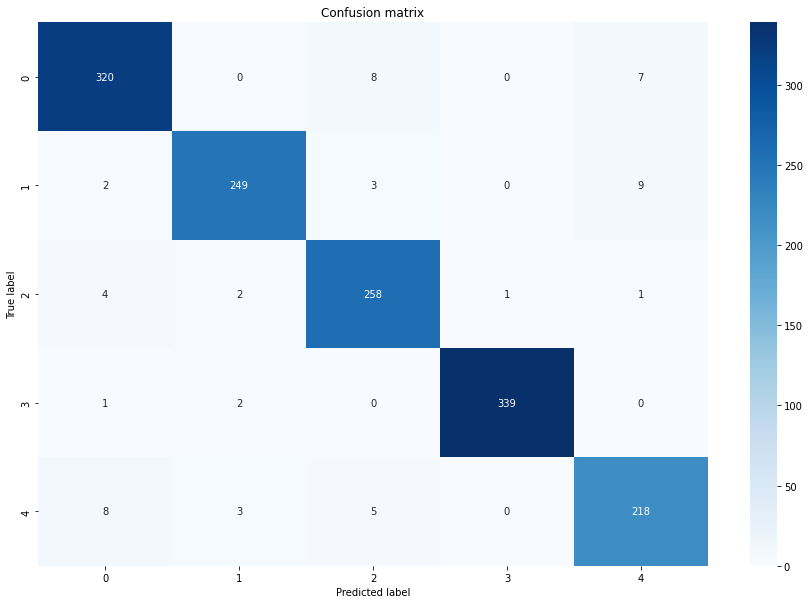

In [839]:

# Permute the rows of the confusion matrix
confusion_matrix_perm = confusion_matrix(y_train, np.argmax(W_perm, axis=1))
# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix_perm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [840]:
# Create a dataframe with articleid, text, category and predicted category
df_pred = pd.DataFrame({'ArticleId': df_train['ArticleId'], 'Text': df_train['Text'], 'Category': df_train['Category'], 'PredictedCategory': np.argmax(W_perm, axis=1)})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['Category'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
df_pred['PredictedCategory'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)


,ArticleId,Text,Category,PredictedCategory
0,1833,worldcom ex boss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom ex head intern account alert director irregular account practic us telecom giant warn led collaps firm follow discoveri bn bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book howev ms cooper said mr sullivan mention anyth uncomfort worldcom account audit committe meet mr ebber could face jail sentenc year convict charg face worldcom emerg bankruptci protect known mci last week mci agre buyout verizon commun deal valu bn,business,business
1,154,german busi confid slide german busi confid fell februari knock hope speedi recoveri europ largest economi munich base research institut ifo said confid index fell februari januari first declin three month studi found outlook manufactur retail sector worsen observ hope confid busi sector would signal econom activ pick surpris ifo index taken knock said dz bank economist bernd weidenstein main reason probabl domest economi still weak particularli retail trade economi labour minist wolfgang clement call dip februari ifo confid figur mild declin said despit retreat index remain rel high level expect modest econom upsw continu germani economi grew last year shrink howev economi contract last three month mainli due reluct consum spend latest indic growth still prove elus ifo presid han werner sinn said improv german domest demand sluggish export kept thing go first half demand export hit valu euro hit record level make german product less competit oversea top unemploy rate stuck close manufactur firm includ daimlerchrysl siemen volkswagen negoti union cost cut measur analyst said ifo figur germani continu problem may delay interest rate rise european central bank eurozon interest rate comment senior offici recent focus threat inflat prompt fear interest rate may rise,business,business
2,1101,bbc poll indic econom gloom citizen major nation survey bbc world servic poll believ world economi worsen respond also said nation economi get wors ask famili financi outlook major countri said posit futur almost peopl countri question poll mostli conduct asian tsunami disast poll found major plural peopl countri believ economi go downhil compar respond nine countri believ improv survey three countri split percentag term averag respond countri said world economi get wors compar said improv similarli pessimist nation economi optimist saw famili econom condit improv said get wors poll peopl conduct intern poll firm globescan togeth program intern polici attitud pipa univers maryland world economi pick difficult time year ago peopl seem fulli absorb develop though person experienc effect said pipa director steven kull peopl around world say ok world may percept war terror religi polit divis make world wors place even though far reflect global econom perform say bbc elizabeth blunt countri peopl optimist world famili two fast grow develop economi china india follow indonesia china seen two decad blister econom growth led wealth creation huge scale say bbc louisa lim beij result also may reflect untrammel confid peopl subject endless govern propaganda countri rosi econom futur correspond say south korea pessimist respond itali mexico also quit gloomi bbc david willey rome say one reason result changeov li

In [846]:

X_ = vectorizer.fit_transform(df_test['Text']).toarray()
y_hat = nmf.fit_transform(X_)
#index with highest probability is our predicted class
y_hat = np.argmax(y_hat, axis=1)

# create dataframe
y_hat = pd.DataFrame(y_hat)

# assign best labelorder to prediction
y_hat = y_hat.replace(np.unique(y_hat), [0, 3, 2, 1, 4])
y_hat.head()







,0
0,3
1,1
2,3
3,0
4,3


In [847]:
# Create a dataframe with articleid, text and predicted category
df_pred = pd.DataFrame({'ArticleId': df_test['ArticleId'],  'PredictedCategory': y_hat[0]})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

# Remove predicted category column
df_pred.drop('PredictedCategory', axis=1, inplace=True)


In [848]:
df_pred.shape
df_pred.to_csv('submission.csv', index=False)